In [1]:
###### check environments ######

import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])

ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
ocid1.datascienceproject.oc1.eu-zurich-1.amaaaaaa2jwq32iapkcl4klg3qulxmpxlgnyxwhf276mb6ukgtdhms5oc3ua
ocid1.saml2idp.oc1..aaaaaaaao4zb7iwgmzbhs3hcvl7qrob453qzrqzs3o2hhl23oczezxmtyz7q/ethlambda@gmail.com
ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
eu-zurich-1


In [21]:
%%bash
###### install libs ######
#pip install matplotlib
#pip install pandas
#pip install seaborn
#pip list
#pip install scikit-learn

In [2]:
###### import libs ######

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import pickle
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

In [3]:
###### check ads env ######

ads.environment.ads_inspect.check_ads_env()

Library         Version    Required
--------------  ---------  ----------
arrow           0.14.7     0.10.0
configparser    4.0.2      3.5.0
ipykernel       5.4.0      5.1.3
pyod            0.8.1      0.7.1
pyOpenSSL       18.0.0     19.0
pytest          4.0.1      5.3.5
pytest-asyncio  0.9.0      0.10.0
six             1.14.0     1.13


In [5]:
####### load data #######

name = 'd_phy'
id_col = "id"
target_col = "signal"

train_name = './d_phy/train_{}.csv'.format(name)
test_name = './d_phy/test_{}.csv'.format(name)

df = pd.read_csv(train_name)
test_df = pd.read_csv(test_name)

print(df.head())
print(df.shape)

print(test_df.head())
print(test_df.shape)

         id  LifeTime      dira  FlightDistance  FlightDistanceError  \
0   8750983  0.001668  0.999993       14.222345             0.266628   
1  13765376  0.001585  0.999998       18.465176             0.436901   
2  11194060  0.000905  0.999991       20.513996             0.785390   
3  13621518  0.001776  0.999971       11.252247             0.360682   
4   4663672  0.000559  1.000000        4.766548             0.281022   

         IP     IPSig  VertexChi2           pt   DOCAone  ...          p1_p  \
0  0.052289  2.547194    1.130356  2146.897217  0.024422  ...  32946.644531   
1  0.035555  2.905930    3.945476  4866.848145  0.016601  ...  25935.441406   
2  0.089674  6.566642   10.508627  6510.605469  0.022965  ...  66291.375000   
3  0.085447  4.350947    8.471117  1875.686279  0.050227  ...  18539.062500   
4  0.004743  0.389566    0.333618  4228.927734  0.011837  ...  14566.449219   

           p2_p    p0_eta    p1_eta    p2_eta  SPDhits  production  signal  \
0   7270.00048

[ 1.  0. nan]


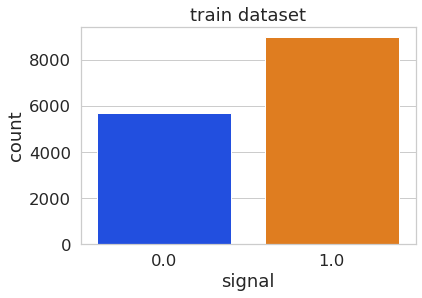

In [6]:
### dataset statistics ######
sns.countplot(x=target_col, data=df)
plt.title("train dataset")
print(df[target_col].unique())

In [7]:
###### train model ######

train = DatasetFactory.open(df).set_target(target_col)
print([train])

# create an automl job
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(training_data = train, provider=ml_engine)

# time budget is in seconds
best_model, baseline = oracle_automl.train(score_metric='roc_auc', time_budget=600)

[BinaryClassificationDataset(target: signal) 14,708 rows, 51 columns]


Training Dataset size,"(14707, 50)"
Validation Dataset size,None
CV,5
Target variable,signal
Optimization Metric,roc_auc
Initial number of Features,50
Selected number of Features,1
Selected Features,[production]
Selected Algorithm,AdaBoostClassifier
End-to-end Elapsed Time (seconds),11.32
Selected Hyperparameters,"{'learning_rate': 0.0009965527343750002, 'n_estimators': 100}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,AdaBoostClassifier_AS,5000,50,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.5793
3,AdaBoostClassifier_ANOVAF_FS,14707,4,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.0641
4,AdaBoostClassifier_MutualInfo_FS,14707,2,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.0799
5,AdaBoostClassifier_AdaBoostClassifier_FS,14707,2,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.0712
6,AdaBoostClassifier_ANOVAF_FS,14707,2,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.0667
...,...,...,...,...,...,...
84,AdaBoostClassifier_RandomForestClassifier_FS,14707,23,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.1350
85,AdaBoostClassifier_MutualInfo_FS,14707,23,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.1427
86,AdaBoostClassifier_ANOVAF_FS,14707,23,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.1397
87,AdaBoostClassifier_AVGRanking_FS,14707,28,1.0,"{'n_estimators': 100, 'learning_rate': 0.667}",0.1661


In [9]:
###### predict test dataset ######

print(test_df.shape)

y_pred = best_model.predict(test_df)
y_pred_prob = best_model.predict_proba(test_df)
y_true = test_df[target_col]
print(y_true.shape)
print(y_pred_prob.shape)

test_acc = np.mean(y_pred==y_true)
print("test accuracy = {}".format(test_acc))

import sklearn
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob[:,1], pos_label=1)
test_auc = metrics.auc(fpr, tpr)
print("test auc = {}".format(test_auc))

(6756, 51)
(6756,)
(6756, 2)
test accuracy = 1.0
test auc = 1.0


In [9]:
oracle_automl.print_trials(max_rows=129, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
RandomForestClassifier_HT,705420,4,0.7269,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00010721881944315313, 'min_samples_split': 0.00125, 'n_estimators': 100}",362.7311
RandomForestClassifier_HT,705420,4,0.7259,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00011221880526720122, 'min_samples_split': 0.00125, 'n_estimators': 100}",344.9307
RandomForestClassifier_HT,705420,4,0.7028,"{'class_weight': 'balanced', 'max_features': 0.7777852780000001, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 100}",292.5517
RandomForestClassifier_HT,705420,4,0.7028,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 100}",292.1653
RandomForestClassifier_HT,705420,4,0.7028,"{'class_weight': None, 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 100}",310.3100
RandomForestClassifier_AdaBoostClassifier_FS,705420,4,0.7028,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",285.4437
RandomForestClassifier_HT,705420,4,0.7027,"{'class_weight': 'balanced_subsample', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 100}",331.8362
RandomForestClassifier_AdaBoostClassifier_FS,705420,2,0.7027,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",263.6698
RandomForestClassifier_MutualInfo_FS,705420,4,0.7025,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",497.2083
RandomForestClassifier_RandomForestClassifier_FS,705420,7,0.7010,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",561.5794


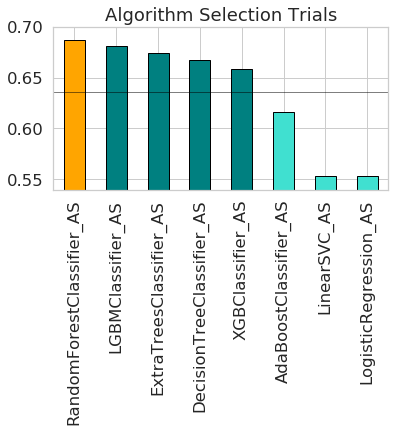

In [10]:
oracle_automl.visualize_algorithm_selection_trials()

In [10]:
###### load kaggle test dataset ######
kaggle_test_name = './d_phy/kaggle-test_{}.csv'.format(name)

kaggle_test_df = pd.read_csv(kaggle_test_name)
kaggle_test_id = np.array(kaggle_test_df[id_col])

print(kaggle_test_df.head())
kaggle_test_df.shape

         id  LifeTime      dira  FlightDistance  FlightDistanceError  \
0  14711831  0.001273  0.999816        8.569642             0.310039   
1  16316387  0.000661  0.999954        7.061379             0.348772   
2   6771382  0.000889  0.999999        6.502967             0.273914   
3    686045  0.001295  0.999301        7.838184             0.325697   
4   8755882  0.001714  0.999805        7.064559             0.113440   

         IP      IPSig  VertexChi2           pt   DOCAone  ...        p0_pt  \
0  0.197893   5.183939    2.286117   687.479248  0.022301  ...   508.926514   
1  0.067430   6.316281    3.865824  5691.845703  0.002455  ...   943.130676   
2  0.011020   0.865816    1.004631  5429.225586  0.002753  ...  2886.055908   
3  0.388636  11.391245   10.345356   661.717834  0.008163  ...   461.727753   
4  0.154421  13.925871   12.951378  3885.417969  0.066317  ...  1773.747925   

         p1_pt        p2_pt          p0_p          p1_p          p2_p  \
0   306.629456   71

(855819, 47)

In [11]:
###### predict kaggle test dataset ######

kaggle_y_pred = best_model.predict(kaggle_test_df)

assert kaggle_y_pred.shape == kaggle_test_id.shape

print(kaggle_y_pred.shape)
print(kaggle_y_pred[:100])

AssertionError: Mismatch between column types and number of features 50 != 47

In [16]:
###### save kaggle prediction ######

target_col = "prediction"
kaggle_pred_name = './d_phy/kaggle-test_{}_predictions.csv'.format(name)

kaggle_pred_df = pd.DataFrame({id_col: kaggle_test_id, target_col: kaggle_y_pred})
print(kaggle_pred_df.head())

kaggle_pred_df.to_csv(kaggle_pred_name, index=False)

    activity_id  outcome
0   act1_249281        0
1   act2_230855        0
2   act1_240724        0
3    act1_83552        0
4  act2_1043301        1
